In [1]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="data/luis/FN_PLU_2017-2021_Twitter_def_v1.csv"
df = pd.read_csv(dataset)



In [2]:
noticias = df.Message
len(noticias)

5364

In [3]:
import re
# Remove Emails
noticias = [re.sub(r'\S*@\S*\s?', '', sent) for sent in noticias]

# Remove new line characters
noticias = [re.sub(r'\s+', ' ', sent) for sent in noticias]

# Remove distracting single quotes
noticias= [re.sub("\'", "", sent) for sent in noticias]

# Remove links
noticias = [re.sub(r'\S*http\S*\s?', '', sent) for sent in noticias]
noticias = [re.sub(r'\S*https\S*\s?', '', sent) for sent in noticias]


In [4]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens


**LDA con estimación variacional**

In [6]:
#Aplicando Modelos Probabilistas de Tópicos y LDA
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import LatentDirichletAllocation

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

myStopWords=['gnl','=','$','+','a','e','o','u','y',' ','  ','   ','    ']

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words=myStopWords,tokenizer=spacy_tokenizer, ngram_range=(1,1))
tf = tf_vectorizer.fit_transform(noticias)
diccionario= tf_vectorizer.get_feature_names()

In [7]:
from random import sample
num= tf.shape[0]
num1 = int(0.85*num)
ind = range(0,num)
ind = pd.Series(ind)
ind1 = ind.sample(num1)
train = tf[ind1]
ind2 = ind.index.difference(ind1)
test = tf[ind2]


In [37]:
import math
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [60]:
perp1 = []
perp2 =[]
c_umass =[]
numk = range(1,10)
for k in numk:
    #Estimación de LDA con Bayes Variacional
    lda = LatentDirichletAllocation(n_components=k, max_iter=100,
                                learning_method='online',
                                learning_offset=10.,
                                random_state=0)

    lda.fit(train)
    #Cálculo de índice de ajuste de los datos
    perp1.append(lda.perplexity(train))
    perp2.append(lda.perplexity(test))
    c_umass.append(get_average_topic_coherence(tf, lda.components_, 10))



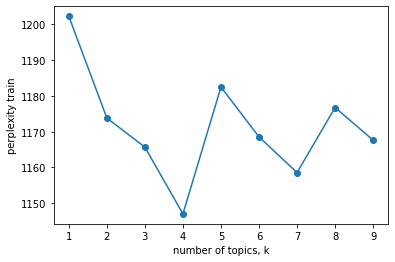

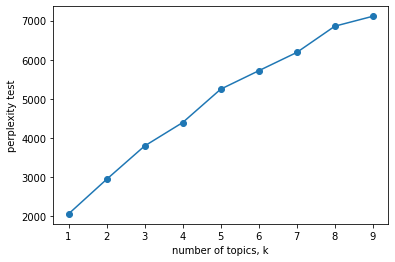

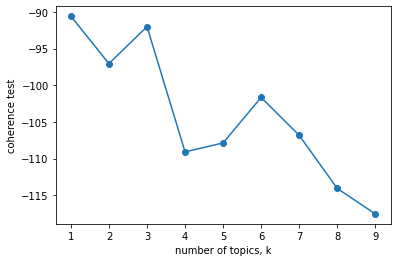

In [61]:
import matplotlib.pyplot as plt
plt.plot(numk, perp1, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity train')
plt.xticks(numk)
plt.show()

plt.plot(numk, perp2, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity test')
plt.xticks(numk)
plt.show()

plt.plot(numk, c_umass, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('coherence test')
plt.xticks(numk)
plt.show()


In [68]:
lda = LatentDirichletAllocation(n_components=4, max_iter=1000,
                                learning_method='online',
                                learning_offset=10.,
                                random_state=0)

lda.fit(train)
perp = lda.perplexity(test)

In [69]:
perp = lda.perplexity(train)
print(perp)

1143.282095892362


In [12]:
import sys
print(sys.version)

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]


In [70]:
import math
avg_coherence = get_average_topic_coherence(tf, lda.components_, 10)
print(avg_coherence)


-110.20250875465892


In [65]:
def proportion_unique_words(topics, topk=10):
    """
    compute the proportion of unique words
    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity will be computed
    """
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk]))
        puw = len(unique_words) / (topk * len(topics))
        return puw

In [71]:
n_top_words=25
topics = []
numo =np.arange(0,n_top_words)
for idx,topic in enumerate(lda.components_):
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
    topics.append(s)    
 

In [72]:
diversity = proportion_unique_words(topics,topk=25)
print(diversity)

0.72


In [74]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
prepared = pyLDAvis.sklearn.prepare(lda,tf,tf_vectorizer)
pyLDAvis.display(prepared)

/home/eliana/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/eliana/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
